<a href="https://colab.research.google.com/github/Ankit-dev-ui/plant-disease-detection-modal/blob/main/ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1. Setup and Dataset Preparation
!wget -O "dataset.zip" "https://data.mendeley.com/public-files/datasets/tywbtsjrjv/files/b4e3a32f-c0bd-4060-81e9-6144231f2520/file_downloaded"

!unzip /content/dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Plant_leave_diseases_dataset_with_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (132).JPG  
  inflating: Plant_leave_diseases_dataset_with_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1320).JPG  
  inflating: Plant_leave_diseases_dataset_with_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1321).JPG  
  inflating: Plant_leave_diseases_dataset_with_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1322).JPG  
  inflating: Plant_leave_diseases_dataset_with_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1323).JPG  
  inflating: Plant_leave_diseases_dataset_with_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1324).JPG  
  inflating: Plant_leave_diseases_dataset_with_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1325).JPG  
  inflating: Plant_leave_diseases_dataset_with_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1326).JPG  
  infl

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
!pip install split-folders
import splitfolders
splitfolders.ratio('/content/Plant_leave_diseases_dataset_with_augmentation', output="dataset", seed=1337, ratio=(.8, .1, .1))


Copying files: 61486 files [00:11, 5154.85 files/s]


In [ ]:
# 2. Dataset Loading
train_dir = "/content/dataset/train"
validation_dir = "/content/dataset/val"
test_dir = "/content/dataset/test"

BATCH_SIZE = 32
IMG_SIZE = (224, 224)  # ResNet50 input size

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir, batch_size=BATCH_SIZE, image_size=IMG_SIZE)

class_names = train_dataset.class_names


Found 49179 files belonging to 39 classes.
Found 6139 files belonging to 39 classes.
Found 6168 files belonging to 39 classes.


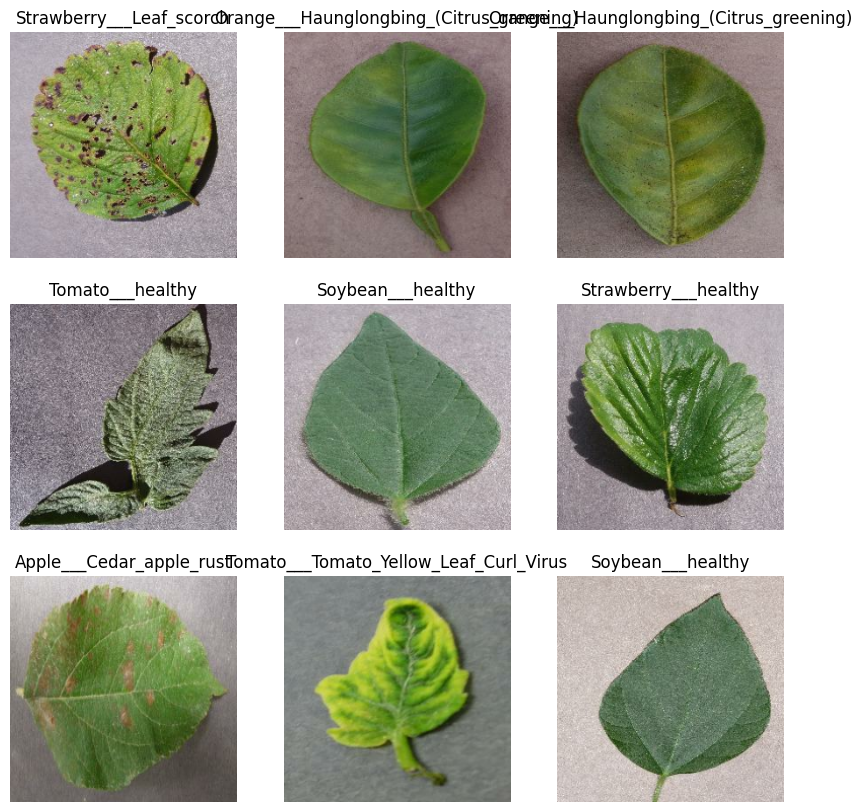

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

preprocess_input = tf.keras.applications.resnet.preprocess_input                  # Rescales pixel values from [0, 255] to [-1, 1]

In [ ]:
import pandas as pd

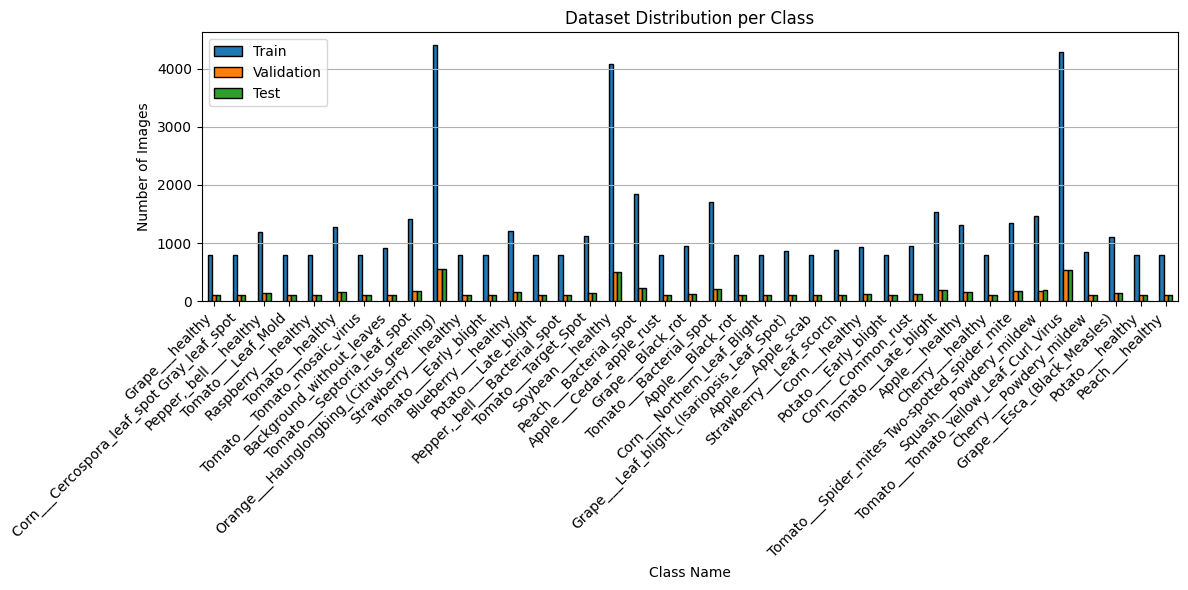

In [ ]:
# Dataset Distribution Plot

def get_class_distribution(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

# Get counts
train_counts = get_class_distribution(train_dir)
val_counts = get_class_distribution(validation_dir)
test_counts = get_class_distribution(test_dir)

# Convert to DataFrame
df_dist = pd.DataFrame({
    "Train": pd.Series(train_counts),
    "Validation": pd.Series(val_counts),
    "Test": pd.Series(test_counts)
}).fillna(0).astype(int)

# Plot
df_dist.plot(kind='bar', figsize=(12, 6), edgecolor='black')
plt.title('Dataset Distribution per Class')
plt.xlabel('Class Name')
plt.ylabel('Number of Images')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [ ]:
# 3. Model Building with ResNet50
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
base_model.trainable = False

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(len(class_names), activation='softmax')

inputs = tf.keras.Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')])


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# 4. Initial Training
initial_epochs = 6
loss0, accuracy0 = model.evaluate(validation_dataset)

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

# 5. Fine-Tuning
base_model.trainable = True
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')])

fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)



192/192 ━━━━━━━━━━━━━━━━━━━━ 32s 97ms/step - accuracy: 0.0565 - loss: 4.1950
Epoch 1/6
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 153s 93ms/step - accuracy: 0.8353 - loss: 0.6540 - val_accuracy: 0.9748 - val_loss: 0.0936
Epoch 2/6
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 201s 95ms/step - accuracy: 0.9701 - loss: 0.0996 - val_accuracy: 0.9819 - val_loss: 0.0670
Epoch 3/6
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 197s 92ms/step - accuracy: 0.9795 - loss: 0.0656 - val_accuracy: 0.9814 - val_loss: 0.0637
Epoch 4/6
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 146s 95ms/step - accuracy: 0.9826 - loss: 0.0554 - val_accuracy: 0.9858 - val_loss: 0.0585
Epoch 5/6
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 203s 95ms/step - accuracy: 0.9850 - loss: 0.0454 - val_accuracy: 0.9816 - val_loss: 0.0640
Epoch 6/6
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 197s 92ms/step - accuracy: 0.9854 - loss: 0.0414 - val_accuracy: 0.9852 - val_loss: 0.0553
Epoch 6/16
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 314s 184ms/step - accuracy: 0.8874 - loss: 0.6742 - val_accuracy: 0.9891 - val_loss: 0.05

In [ ]:
# 6. Evaluation
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

# 7. Metrics: Confusion Matrix, Classification Report, ROC
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns


193/193 ━━━━━━━━━━━━━━━━━━━━ 20s 101ms/step - accuracy: 0.9963 - loss: 0.0152
Test accuracy : 0.9952983260154724


In [ ]:
# Get predictions
y_true = []
y_pred = []
y_score = []

for images, labels in test_dataset:
    preds = model.predict(images)
    y_score.extend(preds)
    pred_labels = tf.argmax(preds, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(pred_labels.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_score = np.array(y_score)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

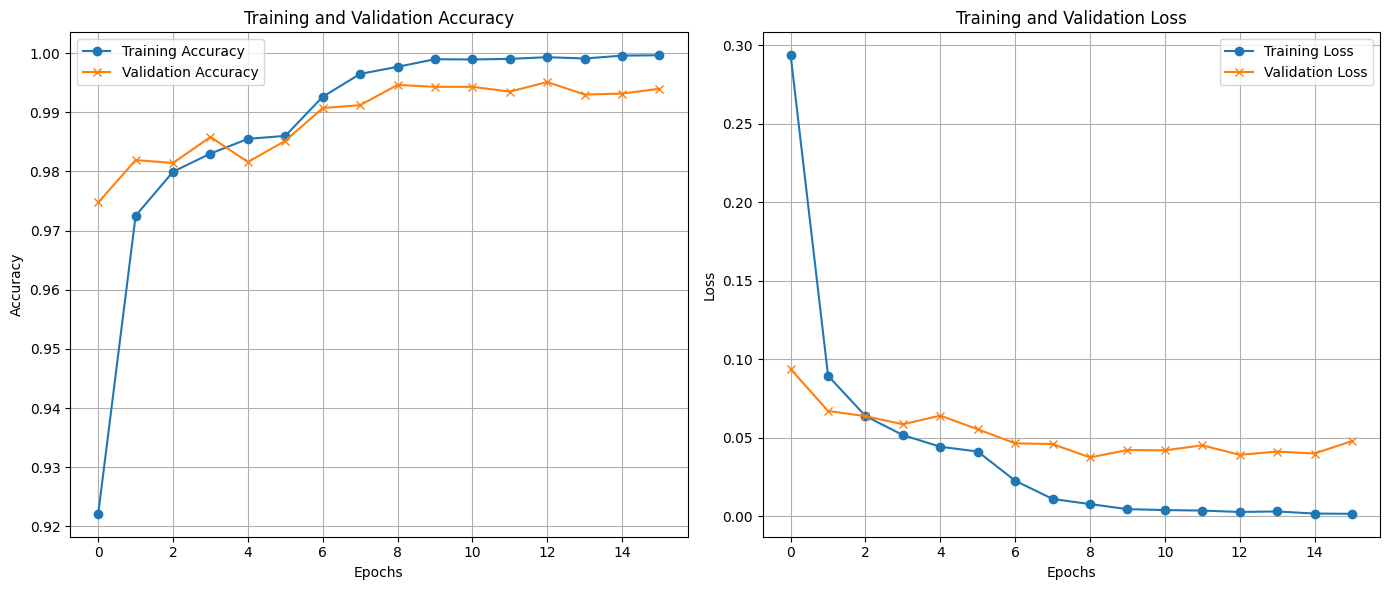

In [ ]:
# Training & Validation Graphs
acc = history.history['accuracy'] + history_fine.history['accuracy'][1:]
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy'][1:]

loss = history.history['loss'] + history_fine.history['loss'][1:]
val_loss = history.history['val_loss'] + history_fine.history['val_loss'][1:]

epochs_range = range(len(acc))  # or use total_epochs - 1

plt.figure(figsize=(14, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='x')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='x')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


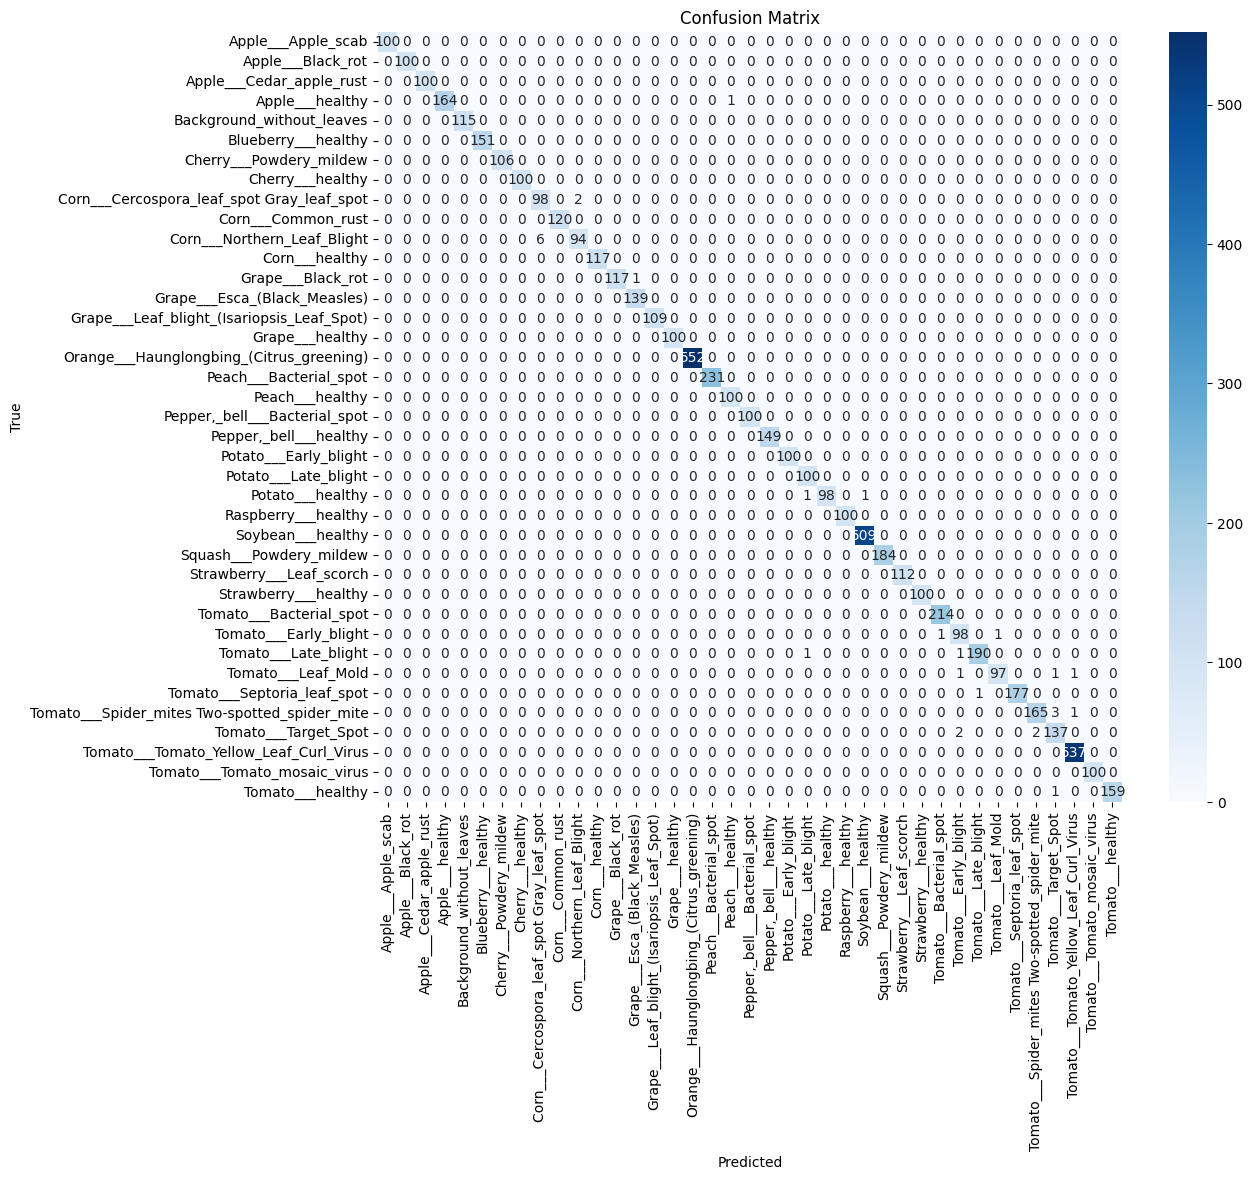

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


Classification Report:

                                               precision    recall  f1-score   support

                           Apple___Apple_scab       1.00      1.00      1.00       100
                            Apple___Black_rot       1.00      1.00      1.00       100
                     Apple___Cedar_apple_rust       1.00      1.00      1.00       100
                              Apple___healthy       1.00      0.99      1.00       165
                    Background_without_leaves       1.00      1.00      1.00       115
                          Blueberry___healthy       1.00      1.00      1.00       151
                      Cherry___Powdery_mildew       1.00      1.00      1.00       106
                             Cherry___healthy       1.00      1.00      1.00       100
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.94      0.98      0.96       100
                           Corn___Common_rust       1.00      1.00      1.00       120
                  

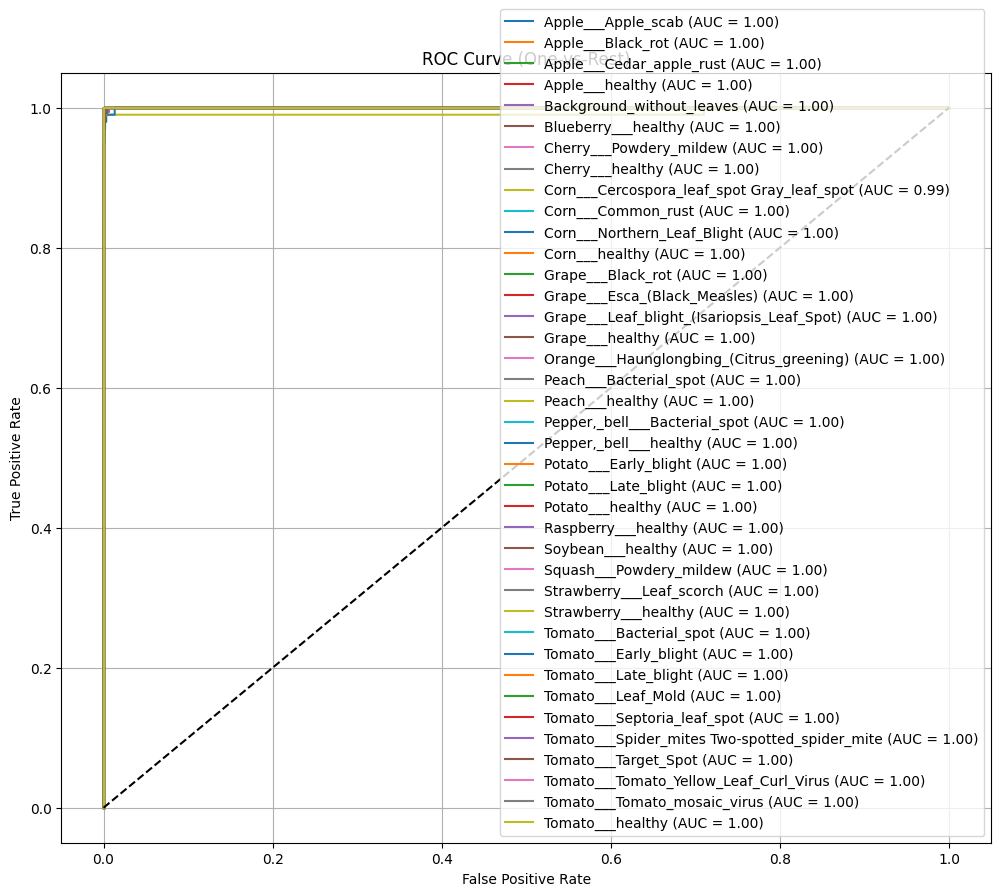

In [ ]:
# ROC Curve
y_true_bin = label_binarize(y_true, classes=list(range(len(class_names))))
plt.figure(figsize=(12, 10))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (One-vs-Rest)')
plt.legend(loc='lower right')
plt.grid()
plt.show()


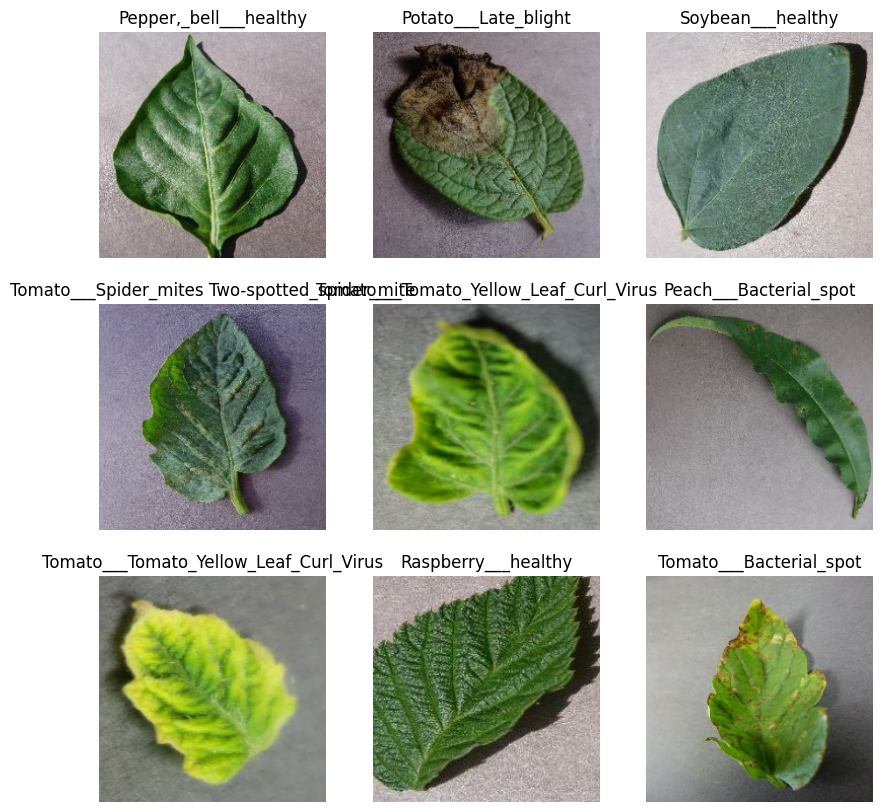

In [ ]:
# 8. Visualize Predictions
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
predictions = tf.argmax(predictions, axis=1)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")


In [ ]:
# 9. Save Model
model.save("plant_disease_recog_resnet50.keras")
model.save("/content/drive/MyDrive/plant_disease_recog_resnet50.keras")

NameError: name 'model' is not defined